# PRIMO - The P&A Project Optimizer
## Workflow Demo 

This notebook contains a demo of PRIMO - The P&A Project Optimizer. Utilizing the workflow in the image below, PRIMO reads in  input data on marginal wells and their characteristics and analyzes it with respect to **USER-DEFINED PRIORITIES AND PREFERENCES** to provide recommendations on the design of impactful and efficient P&A projects. 

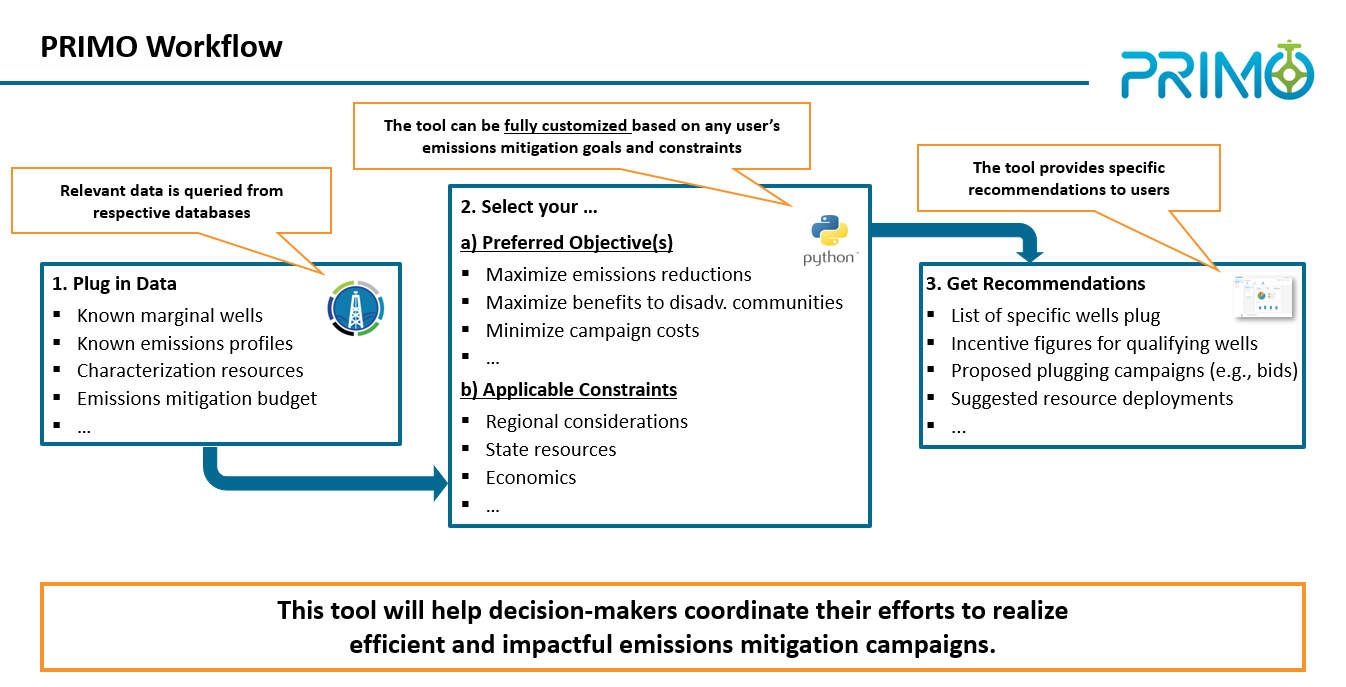

## Priority & Weight Selection Guidelines

Please use the following guidelines when selecting your priorities and their respective weights:
- Use the checkboxes to select preferred priorities and the respective sliders to specify the weight of these 
- Some priorities may also allow for the specification of sub-priorities (e.g., the sensitive receptors priority involves 8 sub-priorities: schools, hospitals, buildings, etc.).
- Use the checkbox to select a sub-priority and the corresponding slider to specify the weight of the sub-priority
- A sub-priority can only be selected if the corresponding "parent" priority has been selected
- The sum of all priorities needs to be 100
- The sum of all sub-priorities within each priority needs to be 100
- If you wish to change the weights after confirming them or getting an error, please re-run this cell in order to get a fresh start

## Using Config File to Provide Inputs

PRIMO utilizes a .json config file to define priority metrics, efficiency metrics, and constraints. Users can also specify default paths for input data files and output files. The current demo includes a config file - config_example.json. For detailed guidance on the purpose, construction, and modification of the config file, please refer to the documentation [Config File](https://primo.readthedocs.io/en/.html). (This link needs to be updated once the documentation is connected to readthedocs)

## Notice

This demo uses randomized data on a 2-d grid (x and y coordinates). Here, the x-coordinate represents the latitude, and the y-coordinate represents the longitude of a well. The demo results are accordingly visualized in scatter plots. 

PRIMO is designed to process geospatial data containing latitude and longitude information such as shapefiles and also queries data from external sources such as U.S. Census. PRIMO also has utilities available to plot visualizations using maps instead of 2-d grids. 

This notebook is primarily meant to showcase the workflow and functionality of PRIMO. PRIMO is under active development: please reach out to primo@netl.doe.gov for questions, comments, feedback or feature requests.

In [7]:
# Imports from installed libraries
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# PRIMO imports
from primo.data_parser import (
    EfficiencyMetrics,
    ImpactMetrics,
    WellDataColumnNames
)
from primo.data_parser.well_data import WellData
from primo.opt_model.result_parser import (
    EfficiencyCalculator,
    export_data_to_excel
)
from primo.opt_model.model_options import OptModelInputs
from primo.utils import setup_logger
from primo.utils.config_utils import UserSelection
from primo.utils.map_utils import get_cluster_colors
from primo.utils.override_utils import OverrideCampaign


# Setup logger
setup_logger()
pd.set_option('display.precision',2)

## Impact Metric Selection

In [8]:
# Define impact metrics by creating an instance of ImpactMetrics class
im_metrics = ImpactMetrics()

im_metrics.register_new_metric(name="classes", weight= 0, full_name="Well Class")

# Specify weights
im_metrics.set_weight(
    primary_metrics={
        "ch4_emissions": 35,
        "sensitive_receptors": 20,
        "ann_production_volume": 20,
        "well_age": 15,
        "well_count": 10,
    },
    submetrics={
        "ch4_emissions": {
            "leak": 40,
            "compliance": 30,
            "violation": 20,
            "incident": 10,
        },
        "sensitive_receptors": {
            "schools": 50,
            "hospitals": 50,
        },
        "ann_production_volume": {
            "ann_gas_production": 50,
            "ann_oil_production": 50,
        }
    }
)

# Check if the weights are valid or not
im_metrics.check_validity()

print(im_metrics)

                                                Metric Name  Metric weight
ch4_emissions                   Methane Emissions (Proxies)             35
dac_impact                   Disadvantaged Community Impact              0
sensitive_receptors                     Sensitive Receptors             20
ann_production_volume              Annual Production Volume             20
five_year_production_volume     Five-year Production Volume              0
well_age                                           Well Age             15
well_count                                 Owner Well Count             10
other_emissions                             Other Emissions              0
well_integrity               Well Integrity Issues [Yes/No]              0
environment                                     Environment              0
classes                                          Well Class              0
                                                      Total            100


Primary metric Methane 

In [9]:
# (OPTIONAL) Metrics/submetrics that are not required can be deleted.
# This is an optional step. As long as their weight is set to zero, metric/submetrics
# that are not needed can still remain in the im_metrics object.
im_metrics.delete_metric("dac_impact")  # Deletes the metric as well submetrics "fed_dac" and "state_dac"
im_metrics.delete_metric("other_emissions")
im_metrics.delete_metric("five_year_production_volume")
im_metrics.delete_metric("well_integrity")
im_metrics.delete_metric("environment")

# Submetrics can also be deleted in a similar manner
im_metrics.delete_submetric("buildings_near")
im_metrics.delete_submetric("buildings_far")

print(im_metrics)

                                       Metric Name  Metric weight
ch4_emissions          Methane Emissions (Proxies)             35
sensitive_receptors            Sensitive Receptors             20
ann_production_volume     Annual Production Volume             20
well_age                                  Well Age             15
well_count                        Owner Well Count             10
classes                                 Well Class              0
                                             Total            100


Primary metric Methane Emissions (Proxies), with weight 35, has submetrics:
                 Submetric Name  Submetric weight
leak              Leak [Yes/No]                40
compliance  Compliance [Yes/No]                30
violation    Violation [Yes/No]                20
incident      Incident [Yes/No]                10
                          Total               100


Primary metric Sensitive Receptors, with weight 20, has submetrics:
          Submetric Name

In [10]:
# # Alternatively, use the widget to set weights
# im_metrics_widget = im_metrics.build_widget()
# im_metrics_widget.display()

In [11]:
# # Update weights from the widget
# im_metrics.set_weight_from_widget(im_metrics_widget)

## Efficiency Metric Selection

In [12]:
# Efficiency metrics can be set in a similar manner
eff_metrics = EfficiencyMetrics()

# Set weights for the metrics
eff_metrics.set_weight(
    primary_metrics={
        "num_wells": 20,
        "num_unique_owners": 30,
        "avg_elevation_delta": 20,
        "age_range": 10,
        "depth_range": 20,
    }
)

# Check validity of the metrics
eff_metrics.check_validity()

# Print the updated metrics
print(eff_metrics)

                                     Metric Name  Metric weight
num_wells                        Number of Wells             20
num_unique_owners        Number of Unique Owners             30
avg_elevation_delta  Average Elevation Delta [m]             20
age_range                      Age Range [Years]             10
depth_range                     Depth Range [ft]             20
record_completeness          Record Completeness              0
avg_dist_to_road        Distance to Road [miles]              0
                                           Total            100


In [13]:
# # Set weights using the widget
# eff_metrics_widget = eff_metrics.build_widget()
# eff_metrics_widget.display()

In [14]:
# # Update weights from the widget
# eff_metrics.set_weight_from_widget(eff_metrics_widget)

## Read Well Data

In [15]:
# Construct an object to store column names
col_names = WellDataColumnNames(
    well_id="API Well Number",
    latitude="x",
    longitude="y",
    operator_name="Operator Name",
    age="Age [Years]",
    depth="Depth [ft]",

    leak="Leak [Yes/No]",
    compliance="Compliance [Yes/No]",
    violation="Violation [Yes/No]",
    incident="Incident [Yes/No]",

    hospitals="Number of Nearby Hospitals",
    schools="Number of Nearby Schools",

    ann_gas_production="Gas [Mcf/Year]",
    ann_oil_production="Oil [bbl/Year]",
    
    # These are columns used in the efficiency calculation
    elevation_delta="Elevation Delta [m]",
    dist_to_road="Distance to Road [miles]",
)

col_names.register_new_columns({"classes":"Well Class"})
im_metrics.classes.data_col_name = "Well Class"
im_metrics.classes.has_inverse_priority=True

# Create the well data object
wd = WellData(data="Example_1_data.csv", column_names=col_names, impact_metrics=im_metrics, efficiency_metrics=eff_metrics)

05-Nov-24 12:37:53 - primo.data_parser.well_data:92 - INFO - Reading the well data from the input file.
05-Nov-24 12:37:53 - primo.data_parser.well_data:118 - INFO - Finished reading the well data.
05-Nov-24 12:37:53 - primo.data_parser.well_data:135 - INFO - Beginning to perform preliminary data checks.
05-Nov-24 12:37:53 - primo.data_parser.well_data:805 - INFO - Checking availability and uniqueness of well ids.
05-Nov-24 12:37:53 - primo.data_parser.well_data:818 - INFO - Checking if latitude and longitude information is available for all wells.
05-Nov-24 12:37:53 - primo.data_parser.well_data:827 - INFO - Checking if the operator name is available for all wells.
05-Nov-24 12:37:53 - primo.data_parser.well_data:846 - INFO - Checking if age of all wells is available.
05-Nov-24 12:37:53 - primo.data_parser.well_data:850 - INFO - Checking if depth of all wells is available.
05-Nov-24 12:37:53 - primo.data_parser.well_data:872 - INFO - Completed processing the essential inputs.
05-Nov-2

### MCW Population Visualization

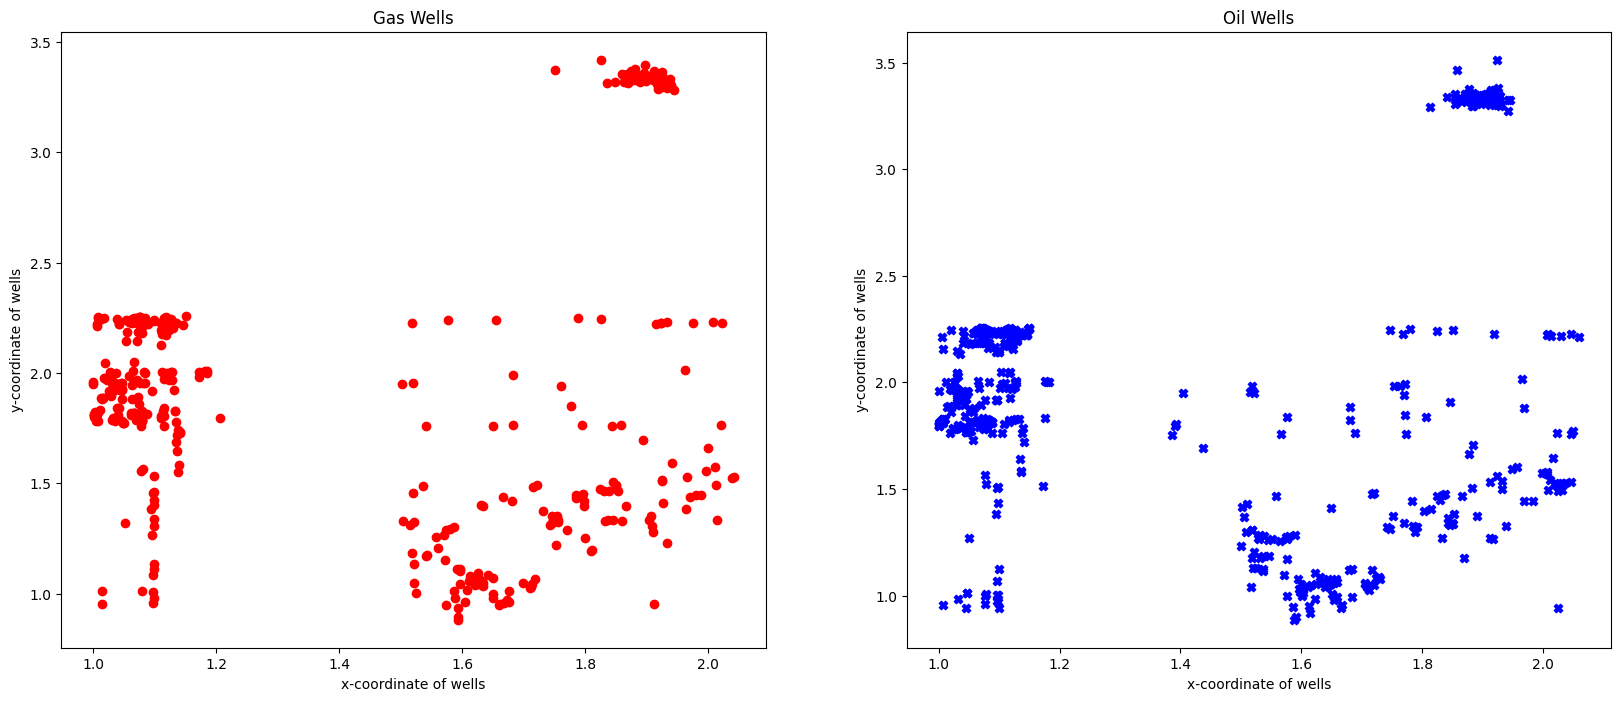

In [16]:
# Split the data data as oil and gas wells
gas_oil_wells = wd.get_gas_oil_wells

# Visualize wells
gas_wells = gas_oil_wells["gas"]   # WellData object
oil_wells = gas_oil_wells["oil"]   # WellData object

well_figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
ax1.scatter(gas_wells.data["x"], gas_wells.data["y"], c='r', marker="o")
ax1.set_title('Gas Wells')
ax1.set(xlabel='x-coordinate of wells', ylabel='y-coordinate of wells')
ax2.scatter(oil_wells.data["x"], oil_wells.data["y"], c='b', marker="X")
ax2.set_title('Oil Wells')
ax2.set(xlabel='x-coordinate of wells', ylabel='y-coordinate of wells')
plt.show()

### Capability 1: Prioritizing Wells
The number of wells under consideration is significantly larger than what can be plugged with the budget available. Hence, we prioritize wells as per user-defined priorities to rank the candidate pool of wells.

In [17]:
# Compute priority scores of gas wells
gas_wells.compute_priority_scores()

05-Nov-24 12:37:53 - primo.data_parser.well_data:1042 - INFO - Computing scores for metric/submetric well_age/Well Age.
05-Nov-24 12:37:53 - primo.data_parser.well_data:1042 - INFO - Computing scores for metric/submetric well_count/Owner Well Count.
05-Nov-24 12:37:53 - primo.data_parser.well_data:1042 - INFO - Computing scores for metric/submetric leak/Leak [Yes/No].
05-Nov-24 12:37:53 - primo.data_parser.well_data:1042 - INFO - Computing scores for metric/submetric compliance/Compliance [Yes/No].
05-Nov-24 12:37:53 - primo.data_parser.well_data:1042 - INFO - Computing scores for metric/submetric violation/Violation [Yes/No].
05-Nov-24 12:37:53 - primo.data_parser.well_data:1042 - INFO - Computing scores for metric/submetric incident/Incident [Yes/No].
05-Nov-24 12:37:53 - primo.data_parser.well_data:1042 - INFO - Computing scores for metric/submetric hospitals/Hospitals.
05-Nov-24 12:37:53 - primo.data_parser.well_data:1042 - INFO - Computing scores for metric/submetric schools/Schoo

In [18]:
# Compute priority scores of oil wells
oil_wells.compute_priority_scores()

05-Nov-24 12:37:53 - primo.data_parser.well_data:1042 - INFO - Computing scores for metric/submetric well_age/Well Age.
05-Nov-24 12:37:53 - primo.data_parser.well_data:1042 - INFO - Computing scores for metric/submetric well_count/Owner Well Count.
05-Nov-24 12:37:53 - primo.data_parser.well_data:1042 - INFO - Computing scores for metric/submetric leak/Leak [Yes/No].
05-Nov-24 12:37:53 - primo.data_parser.well_data:1042 - INFO - Computing scores for metric/submetric compliance/Compliance [Yes/No].
05-Nov-24 12:37:53 - primo.data_parser.well_data:1042 - INFO - Computing scores for metric/submetric violation/Violation [Yes/No].
05-Nov-24 12:37:53 - primo.data_parser.well_data:1042 - INFO - Computing scores for metric/submetric incident/Incident [Yes/No].
05-Nov-24 12:37:53 - primo.data_parser.well_data:1042 - INFO - Computing scores for metric/submetric hospitals/Hospitals.
05-Nov-24 12:37:53 - primo.data_parser.well_data:1042 - INFO - Computing scores for metric/submetric schools/Schoo

#### Outstanding: Filtering by MERP Volunteers

The MERP is a voluntary program for well owners.

#### Displaying High-Priority Wells

After applying all previously selected priority calculations, we display the highest-scoring wells below.


In [19]:
display(Markdown(
"""
#### Gas Wells by Priority Scores
"""
))

# List of columns to display
cols_to_display = [
    col_names.well_id, col_names.operator_name, col_names.age, col_names.depth, col_names.classes, "Priority Score [0-100]"
]

top_gas_wells = gas_wells.data.sort_values(by="Priority Score [0-100]", ascending=False)
display(top_gas_wells[cols_to_display].head(10))


#### Gas Wells by Priority Scores


API Well Number Operator Name  Age [Years]  Depth [ft]  Well Class  \
876           49439      Owner 19          126        1781           2   
860           58584     Owner 236          121       12639           9   
901           21486      Owner 58          124       10416          10   
864           26239     Owner 111          106       12852           8   
858           73984     Owner 142          122        3796           5   
912           35551     Owner 151          145        6845           1   
829           84290       Owner 2           84        2261           4   
495           21580     Owner 224          135        5192           4   
843           97876     Owner 183          111       10459          10   
67            50038     Owner 117           83        5892           8   

     Priority Score [0-100]  
876                   80.28  
860                   73.89  
901                   72.85  
864                   71.46  
858                   71.01  
912                   70.71  
829                   70.03  
495                   69.85  
843                   69.67  
67                    69.64

In [20]:
display(Markdown(
"""
#### Oil Wells by Priority Scores
"""
))

top_oil_wells = oil_wells.data.sort_values(by="Priority Score [0-100]", ascending=False)
display(top_oil_wells[cols_to_display].head(10))


#### Oil Wells by Priority Scores


API Well Number Operator Name  Age [Years]  Depth [ft]  Well Class  \
163           21133      Owner 53          148        4199           1   
819           27016     Owner 108           47        1191           2   
781           22370     Owner 194          144        4565           9   
776           44388     Owner 137          139       11323           3   
856           55133      Owner 97          128        9581           9   
913           83240      Owner 23          120        9066           2   
798           85318     Owner 102           98        9605           5   
828           67212     Owner 101          136        2536           1   
906           38073     Owner 154          106        3429           3   
47            27084     Owner 104          139        3898           3   

     Priority Score [0-100]  
163                   75.01  
819                   74.79  
781                   74.37  
776                   73.37  
856                   72.80  
913                   71.87  
798                   71.67  
828                   70.01  
906                   69.98  
47                    68.79

## Capability 2: Budget-Specific P&A Projects Optimization 
To determine high-impact, high-efficiency P&A within the available budget, we use an optimization model. The optimization carefully evaluates all possible combinations of wells for plugging projects and helps us select the best campaigns in a data-based, transparent and defensible way.

The goal of the optimization is to seek those P&A projects that are not only impactful but will also lead to the most efficient use of P&A resources. The impact of a P&A project is determined by the priority scores of the wells contained within (as per the calculations outline above). More information on the definition and calculation of the predicted efficiency of a P&A project is provided below.

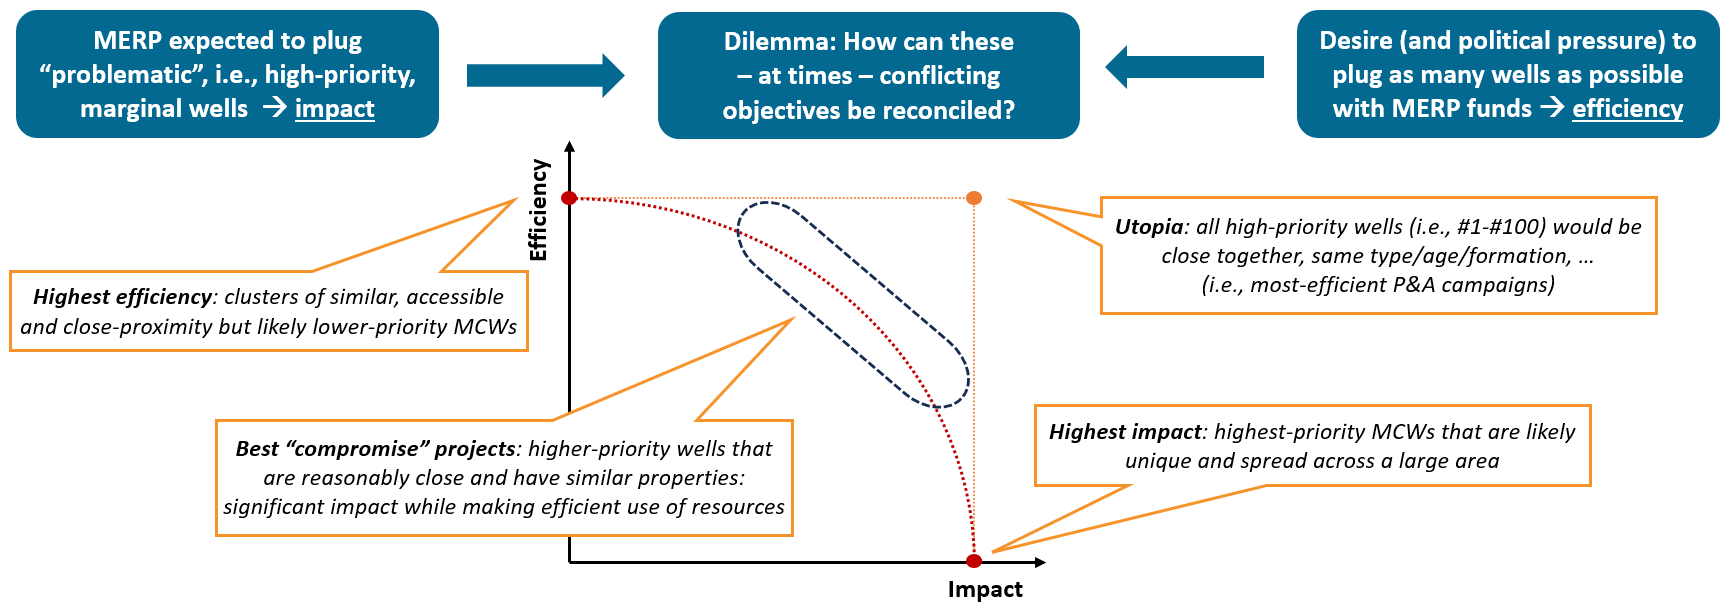

### State-Wide Program Constraints

In [21]:
max_wells_per_owner = 1  #
threshold_distance = 10  # [in miles]
total_budget = 7.5e6     # USD

# Mobilization cost: Assumed to be same for both gas and oil wells
max_num_wells = max([len(gas_wells.data), len(oil_wells.data)])
mobilization_cost = {1: 120000, 2: 210000, 3: 280000, 4: 350000}
for n_wells in range(5, max_num_wells + 1):
    mobilization_cost[n_wells] = n_wells * 84000

# Split the total budget proportionately between gas and oil wells
gas_budget = total_budget * (
    # Fraction of gas wells in the dataset
    len(gas_wells.data) / (len(oil_wells.data) + len(gas_wells.data))
)
oil_budget = total_budget * (
    # Fraction of oil wells in the dataset
    len(oil_wells.data) / (len(oil_wells.data) + len(gas_wells.data))
)

# Set inputs for the optimization models
gas_model_inputs = OptModelInputs(
    well_data=gas_wells,
    total_budget=gas_budget,
    mobilization_cost=mobilization_cost,
    threshold_distance=threshold_distance,
    max_wells_per_owner=max_wells_per_owner,
)

oil_model_inputs = OptModelInputs(
    well_data=oil_wells,
    total_budget=oil_budget,
    mobilization_cost=mobilization_cost,
    threshold_distance=threshold_distance,
    max_wells_per_owner=max_wells_per_owner,
)

05-Nov-24 12:37:53 - primo.opt_model.model_options:167 - INFO - Processing optimization model inputs.
05-Nov-24 12:37:53 - primo.opt_model.model_options:223 - INFO - Finished optimization model inputs.
05-Nov-24 12:37:53 - primo.opt_model.model_options:167 - INFO - Processing optimization model inputs.
05-Nov-24 12:37:54 - primo.opt_model.model_options:223 - INFO - Finished optimization model inputs.


### Clustering Wells to Identify High-Impact, High-Efficiency P&A Candidate Projects
At present, wells are clustered based on proximity and similarity in characteristics (e.g. well age) so they can be organized into IMPACTFUL and EFFICIENT P&A projects. To identify groups of wells that would form a promising set for a project, we apply a constrained clustering algorithm.

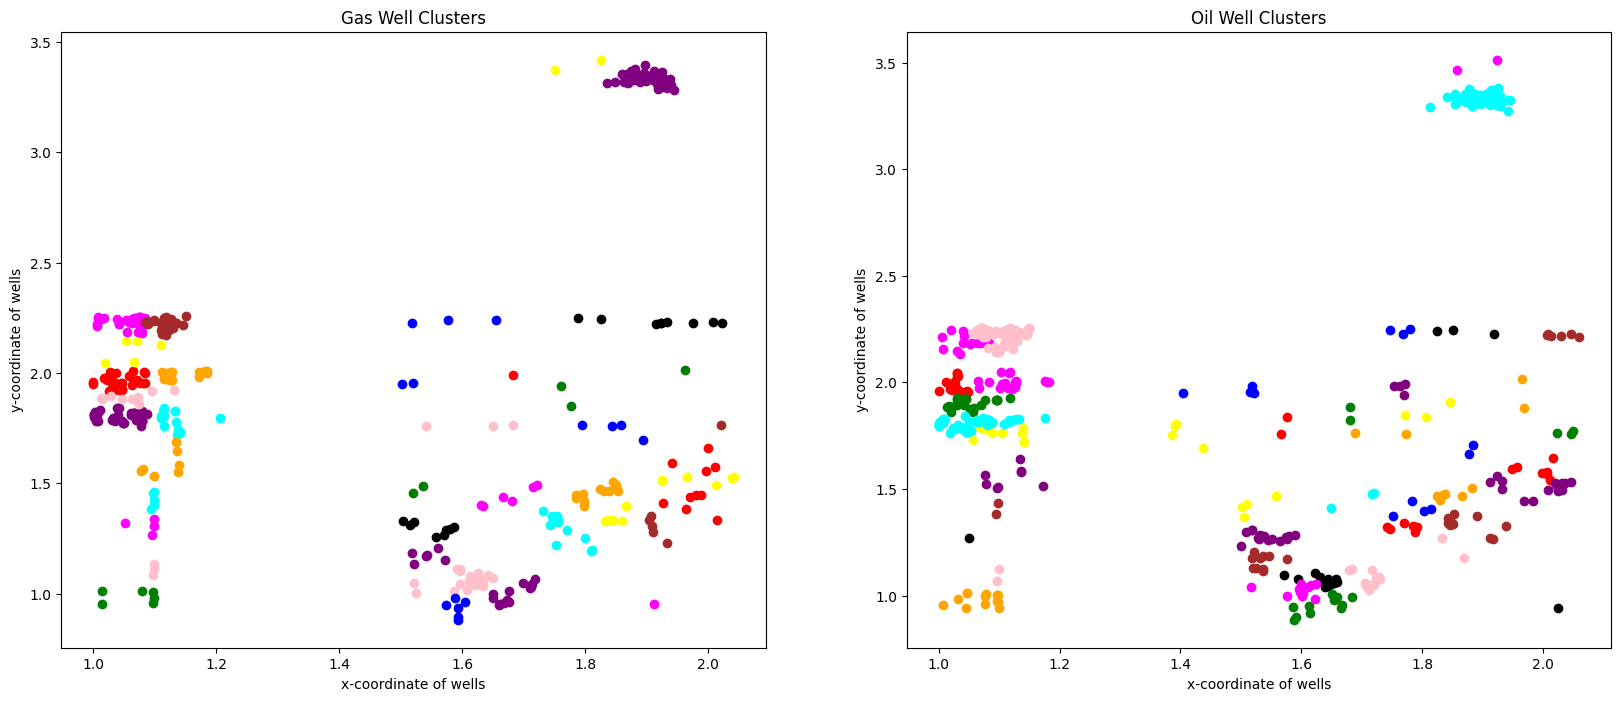

In [22]:
# Use the oil_gdf and gas_gdf pointers defined above
cluster_col_name = "Clusters"
n_clusters_gas = len(set(gas_wells[cluster_col_name]))  # Number of clusters of gas wells
n_clusters_oil = len(set(oil_wells[cluster_col_name]))  # Number of clusters of oil wells

color_list_oil = get_cluster_colors(n_clusters_oil, pd.unique(oil_wells[cluster_col_name]))
color_list_gas = get_cluster_colors(n_clusters_gas, pd.unique(gas_wells[cluster_col_name]))

# Scatter plot of clusters
cluster_figure, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

for cluster in color_list_gas:
    gas_cluster = gas_wells[gas_wells[cluster_col_name] == cluster]
    ax1.scatter(
        gas_cluster[col_names.latitude],
        gas_cluster[col_names.longitude],
        c=color_list_gas[cluster],
    )

ax1.set_title('Gas Well Clusters')
ax1.set(xlabel='x-coordinate of wells', ylabel='y-coordinate of wells')

for cluster in color_list_oil:
    oil_cluster = oil_wells[oil_wells[cluster_col_name] == cluster]
    ax2.scatter(
        oil_cluster[col_names.latitude],
        oil_cluster[col_names.longitude],
        c=color_list_oil[cluster],
    )

ax2.set_title('Oil Well Clusters')
ax2.set(xlabel='x-coordinate of wells', ylabel='y-coordinate of wells')
plt.show()

### Optimizing for P&A Gas Projects 

In [23]:
gas_model_inputs.build_optimization_model()
opt_campaign_gas = gas_model_inputs.solve_model(solver="highs")

05-Nov-24 12:37:54 - primo.opt_model.model_options:281 - INFO - Beginning to construct the optimization model.
05-Nov-24 12:37:54 - primo.opt_model.model_options:283 - INFO - Completed the construction of the optimization model.
05-Nov-24 12:37:54 - pyomo.contrib.appsi.solvers.highs:358 - INFO - Running HiGHS 1.7.2 (git hash: 184e327): Copyright (c) 2024 HiGHS under MIT licence terms
Running HiGHS 1.7.2 (git hash: 184e327): Copyright (c) 2024 HiGHS under MIT licence terms
05-Nov-24 12:37:54 - pyomo.contrib.appsi.solvers.highs:358 - INFO - Coefficient ranges:
05-Nov-24 12:37:54 - pyomo.contrib.appsi.solvers.highs:358 - INFO -   Matrix [1e-01, 5e+01]
05-Nov-24 12:37:54 - pyomo.contrib.appsi.solvers.highs:358 - INFO -   Cost   [2e+01, 8e+01]
05-Nov-24 12:37:54 - pyomo.contrib.appsi.solvers.highs:358 - INFO -   Bound  [1e+00, 1e+00]
05-Nov-24 12:37:54 - pyomo.contrib.appsi.solvers.highs:358 - INFO -   RHS    [1e+00, 3e+00]
05-Nov-24 12:37:54 - pyomo.contrib.appsi.solvers.highs:358 - INFO -

### Optimizing for P&A Oil Projects

In [24]:
oil_model_inputs.build_optimization_model()
opt_campaign_oil = oil_model_inputs.solve_model(solver="highs")

05-Nov-24 12:37:54 - primo.opt_model.model_options:281 - INFO - Beginning to construct the optimization model.
05-Nov-24 12:37:54 - primo.opt_model.model_options:283 - INFO - Completed the construction of the optimization model.
05-Nov-24 12:37:54 - pyomo.contrib.appsi.solvers.highs:358 - INFO - Running HiGHS 1.7.2 (git hash: 184e327): Copyright (c) 2024 HiGHS under MIT licence terms
Running HiGHS 1.7.2 (git hash: 184e327): Copyright (c) 2024 HiGHS under MIT licence terms
05-Nov-24 12:37:55 - pyomo.contrib.appsi.solvers.highs:358 - INFO - Coefficient ranges:
05-Nov-24 12:37:55 - pyomo.contrib.appsi.solvers.highs:358 - INFO -   Matrix [1e-01, 1e+02]
05-Nov-24 12:37:55 - pyomo.contrib.appsi.solvers.highs:358 - INFO -   Cost   [2e+01, 8e+01]
05-Nov-24 12:37:55 - pyomo.contrib.appsi.solvers.highs:358 - INFO -   Bound  [1e+00, 1e+00]
05-Nov-24 12:37:55 - pyomo.contrib.appsi.solvers.highs:358 - INFO -   RHS    [1e+00, 4e+00]
05-Nov-24 12:37:55 - pyomo.contrib.appsi.solvers.highs:358 - INFO -

### RESULT: Summary of PRIMO-Recommended High-Impact, High-Efficiency P&A Gas Projects

In [25]:
opt_campaign_gas.set_efficiency_weights(eff_metrics)
opt_campaign_gas.compute_efficiency_scores()

05-Nov-24 12:37:55 - primo.opt_model.result_parser:646 - INFO - Computing efficiency scores for project 1
05-Nov-24 12:37:55 - primo.opt_model.result_parser:666 - INFO - Computing scores for metric/submetric num_wells/Number of Wells.
05-Nov-24 12:37:55 - primo.opt_model.result_parser:666 - INFO - Computing scores for metric/submetric num_unique_owners/Number of Unique Owners.
05-Nov-24 12:37:55 - primo.opt_model.result_parser:666 - INFO - Computing scores for metric/submetric avg_elevation_delta/Average Elevation Delta [m].
05-Nov-24 12:37:55 - primo.opt_model.result_parser:666 - INFO - Computing scores for metric/submetric age_range/Age Range [Years].
05-Nov-24 12:37:55 - primo.opt_model.result_parser:666 - INFO - Computing scores for metric/submetric depth_range/Depth Range [ft].
05-Nov-24 12:37:55 - primo.opt_model.result_parser:646 - INFO - Computing efficiency scores for project 11
05-Nov-24 12:37:55 - primo.opt_model.result_parser:666 - INFO - Computing scores for metric/submetr

In [26]:
#results for optimal projects for gas
print(opt_campaign_gas)

The optimal campaign has 4 projects.
The total cost of the campaign is $3206000

Number of wells in project 1		: 22
Estimated Project Cost			: $1848000
Impact Score [0-100]			: 68.87
Efficiency Score [0-100]		: 32.23

Number of wells in project 11		: 7
Estimated Project Cost			: $588000
Impact Score [0-100]			: 65.61
Efficiency Score [0-100]		: 48.97

Number of wells in project 13		: 4
Estimated Project Cost			: $350000
Impact Score [0-100]			: 64.01
Efficiency Score [0-100]		: 48.16

Number of wells in project 19		: 5
Estimated Project Cost			: $420000
Impact Score [0-100]			: 64.80
Efficiency Score [0-100]		: 49.31




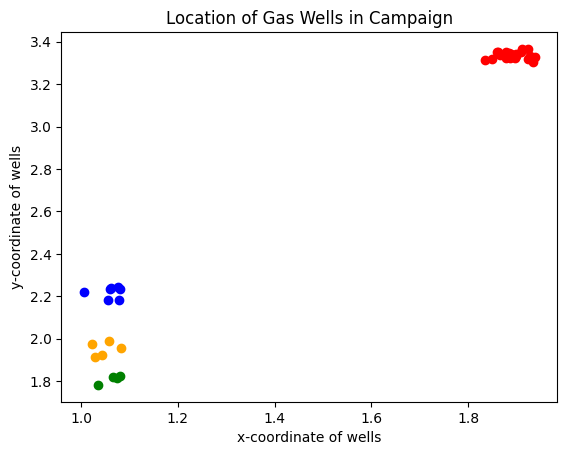

In [27]:
opt_campaign_gas.plot_campaign(title="Location of Gas Wells in Campaign")

In [28]:
# display the information for each project
for project_id, project_data in opt_campaign_gas.get_project_well_information().items():
    display(f"Well information for Project {project_id} with efficiency score : {opt_campaign_gas.get_efficiency_score_project(project_id):.2f}")
    display(project_data)

'Well information for Project 1 with efficiency score : 32.23'

API Well Number Operator Name     x     y  Age [Years]  Depth [ft]  \
789           48446     Owner 126  1.93  3.33           86          65   
807           69687       Owner 7  1.85  3.32          100        1918   
812           84538      Owner 94  1.92  3.32          110       10140   
817           23065     Owner 200  1.93  3.30          113       11419   
829           84290       Owner 2  1.94  3.33           84        2261   
833           91176      Owner 85  1.87  3.34           97        3609   
841           11428     Owner 147  1.90  3.32           92        4007   
843           97876     Owner 183  1.90  3.33          111       10459   
844           47058      Owner 74  1.90  3.34           62        8604   
849           82654     Owner 185  1.90  3.34           94         243   
851           58876      Owner 77  1.89  3.33          109        2428   
858           73984     Owner 142  1.84  3.31          122        3796   
860           58584     Owner 236  1.89  3.34          121       12639   
864           26239     Owner 111  1.88  3.35          106       12852   
874           65647      Owner 71  1.86  3.35           92        3278   
875           53255     Owner 101  1.86  3.35          106       10728   
876           49439      Owner 19  1.89  3.32          126        1781   
897           33690      Owner 13  1.88  3.32           80        8971   
901           21486      Owner 58  1.88  3.35          124       10416   
903           83571     Owner 114  1.92  3.36          123        4691   
907           64266     Owner 195  1.91  3.35          111        9434   
912           35551     Owner 151  1.91  3.37          145        6845   

     Priority Score [0-100]  
789                   67.06  
807                   63.98  
812                   68.82  
817                   67.11  
829                   70.03  
833                   68.28  
841                   65.83  
843                   69.67  
844                   67.11  
849                   65.35  
851                   66.57  
858                   71.01  
860                   73.89  
864                   71.46  
874                   65.44  
875                   66.08  
876                   80.28  
897                   68.90  
901                   72.85  
903                   68.98  
907                   65.83  
912                   70.71

'Well information for Project 11 with efficiency score : 48.97'

API Well Number Operator Name     x     y  Age [Years]  Depth [ft]  \
101           62199     Owner 246  1.05  2.18          125        8108   
108           52884     Owner 115  1.08  2.18          122        4595   
118           79899      Owner 29  1.01  2.22          116        1766   
180           57844      Owner 66  1.08  2.23          150        1140   
272           10241     Owner 188  1.06  2.23          104        1794   
274           37637      Owner 59  1.06  2.24           90        6487   
397           84951     Owner 240  1.08  2.24          148        7900   

     Priority Score [0-100]  
101                   64.71  
108                   65.53  
118                   66.81  
180                   67.65  
272                   65.29  
274                   65.10  
397                   64.16

'Well information for Project 13 with efficiency score : 48.16'

API Well Number Operator Name     x     y  Age [Years]  Depth [ft]  \
49            16079     Owner 120  1.04  1.78           76       10119   
67            50038     Owner 117  1.08  1.83           83        5892   
88            46413      Owner 51  1.07  1.82          142         111   
210           13528     Owner 107  1.07  1.82          142        7216   

     Priority Score [0-100]  
49                    62.84  
67                    69.64  
88                    62.30  
210                   61.28

'Well information for Project 19 with efficiency score : 49.31'

API Well Number Operator Name     x     y  Age [Years]  Depth [ft]  \
21            86095      Owner 65  1.08  1.96           19        2604   
83            28188     Owner 157  1.03  1.92          125        5948   
182           68237       Owner 6  1.04  1.92          126        3965   
280           73758     Owner 169  1.02  1.97          150        7053   
981           69512     Owner 104  1.06  1.99          123        7277   

     Priority Score [0-100]  
21                    69.50  
83                    66.80  
182                   61.62  
280                   63.95  
981                   62.11

### RESULT: Summary of PRIMO-Recommended High-Impact, High-Efficiency P&A Oil Projects

In [29]:
opt_campaign_oil.set_efficiency_weights(eff_metrics)
opt_campaign_oil.compute_efficiency_scores()

05-Nov-24 12:37:55 - primo.opt_model.result_parser:646 - INFO - Computing efficiency scores for project 1
05-Nov-24 12:37:55 - primo.opt_model.result_parser:666 - INFO - Computing scores for metric/submetric num_wells/Number of Wells.
05-Nov-24 12:37:55 - primo.opt_model.result_parser:666 - INFO - Computing scores for metric/submetric num_unique_owners/Number of Unique Owners.
05-Nov-24 12:37:55 - primo.opt_model.result_parser:666 - INFO - Computing scores for metric/submetric avg_elevation_delta/Average Elevation Delta [m].
05-Nov-24 12:37:55 - primo.opt_model.result_parser:666 - INFO - Computing scores for metric/submetric age_range/Age Range [Years].
05-Nov-24 12:37:55 - primo.opt_model.result_parser:666 - INFO - Computing scores for metric/submetric depth_range/Depth Range [ft].
05-Nov-24 12:37:55 - primo.opt_model.result_parser:646 - INFO - Computing efficiency scores for project 5
05-Nov-24 12:37:55 - primo.opt_model.result_parser:666 - INFO - Computing scores for metric/submetri

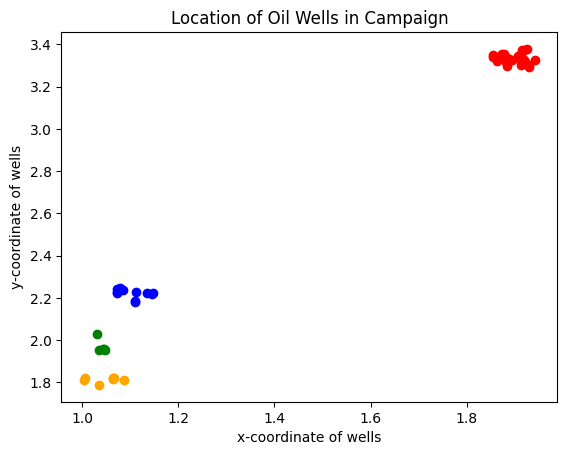

In [30]:
opt_campaign_oil.plot_campaign(title="Location of Oil Wells in Campaign")

In [31]:
for project_id, project_data in opt_campaign_gas.get_project_well_information().items():
    display(f"Well information for Project {project_id} with efficiency score : {opt_campaign_gas.get_efficiency_score_project(project_id):.2f}")
    display(project_data)

'Well information for Project 1 with efficiency score : 32.23'

API Well Number Operator Name     x     y  Age [Years]  Depth [ft]  \
789           48446     Owner 126  1.93  3.33           86          65   
807           69687       Owner 7  1.85  3.32          100        1918   
812           84538      Owner 94  1.92  3.32          110       10140   
817           23065     Owner 200  1.93  3.30          113       11419   
829           84290       Owner 2  1.94  3.33           84        2261   
833           91176      Owner 85  1.87  3.34           97        3609   
841           11428     Owner 147  1.90  3.32           92        4007   
843           97876     Owner 183  1.90  3.33          111       10459   
844           47058      Owner 74  1.90  3.34           62        8604   
849           82654     Owner 185  1.90  3.34           94         243   
851           58876      Owner 77  1.89  3.33          109        2428   
858           73984     Owner 142  1.84  3.31          122        3796   
860           58584     Owner 236  1.89  3.34          121       12639   
864           26239     Owner 111  1.88  3.35          106       12852   
874           65647      Owner 71  1.86  3.35           92        3278   
875           53255     Owner 101  1.86  3.35          106       10728   
876           49439      Owner 19  1.89  3.32          126        1781   
897           33690      Owner 13  1.88  3.32           80        8971   
901           21486      Owner 58  1.88  3.35          124       10416   
903           83571     Owner 114  1.92  3.36          123        4691   
907           64266     Owner 195  1.91  3.35          111        9434   
912           35551     Owner 151  1.91  3.37          145        6845   

     Priority Score [0-100]  
789                   67.06  
807                   63.98  
812                   68.82  
817                   67.11  
829                   70.03  
833                   68.28  
841                   65.83  
843                   69.67  
844                   67.11  
849                   65.35  
851                   66.57  
858                   71.01  
860                   73.89  
864                   71.46  
874                   65.44  
875                   66.08  
876                   80.28  
897                   68.90  
901                   72.85  
903                   68.98  
907                   65.83  
912                   70.71

'Well information for Project 11 with efficiency score : 48.97'

API Well Number Operator Name     x     y  Age [Years]  Depth [ft]  \
101           62199     Owner 246  1.05  2.18          125        8108   
108           52884     Owner 115  1.08  2.18          122        4595   
118           79899      Owner 29  1.01  2.22          116        1766   
180           57844      Owner 66  1.08  2.23          150        1140   
272           10241     Owner 188  1.06  2.23          104        1794   
274           37637      Owner 59  1.06  2.24           90        6487   
397           84951     Owner 240  1.08  2.24          148        7900   

     Priority Score [0-100]  
101                   64.71  
108                   65.53  
118                   66.81  
180                   67.65  
272                   65.29  
274                   65.10  
397                   64.16

'Well information for Project 13 with efficiency score : 48.16'

API Well Number Operator Name     x     y  Age [Years]  Depth [ft]  \
49            16079     Owner 120  1.04  1.78           76       10119   
67            50038     Owner 117  1.08  1.83           83        5892   
88            46413      Owner 51  1.07  1.82          142         111   
210           13528     Owner 107  1.07  1.82          142        7216   

     Priority Score [0-100]  
49                    62.84  
67                    69.64  
88                    62.30  
210                   61.28

'Well information for Project 19 with efficiency score : 49.31'

API Well Number Operator Name     x     y  Age [Years]  Depth [ft]  \
21            86095      Owner 65  1.08  1.96           19        2604   
83            28188     Owner 157  1.03  1.92          125        5948   
182           68237       Owner 6  1.04  1.92          126        3965   
280           73758     Owner 169  1.02  1.97          150        7053   
981           69512     Owner 104  1.06  1.99          123        7277   

     Priority Score [0-100]  
21                    69.50  
83                    66.80  
182                   61.62  
280                   63.95  
981                   62.11

### Manual overrides for existing projects

PRIMO allows users to modify projects manually to satisfy requirements not considered above.

Please use the widgets to select the projects and/or wells:
- Step 1 - Remove Widget: This widget allows you to remove projects and/or wells from the recommended P&A projects.
    - Select P&A projects that should be removed from the recommendations. To confirm your selection, press the "Select Projects to Manually Remove" button. 
    - Select wells that should be removed from the recommended P&A projects. To confirm your selection, press the "Select Wells to Manually Remove" button. 
    - Once you are satisfied with your selections, please press the "Confirm Removal" button to proceed to the next step.
- Step 2 - Add Widget: Use this widget to select wells to be included in the P&A projects. 
    - Select wells using the text box on the left and enter the project in which the well should be included using the text box on the right. If you do not wish to include the well in a specific project, please leave the project text box with its default value, which will appear when you select the well on the left. To confirm your selection, press the "Select Wells to Manually Add" button.
- Step 3 - Lock Widget: his widget is for locking wells and/or projects in the recommended P&A projects during the re-optimization step.
    - Select P&A projects that you are satisfied with and wish to keep. To confirm your selection, press the "Select Projects to Manually Lock" button. 
    - Select wells that should be retained in the recommended P&A projects. To confirm your selection, press the "Select Wells to Manually Lock" button.

Notice:
- If you need to exclude a project or well that has already been selected, please use the "Undo" button associated with the corresponding widget.
- Once you click the "Confirm Removal" button, you will not be able to modify the projects and wells selected for removal. Please re-execute the cell below to restart your selection.
- If you do not want to remove, add, or lock any projects or wells, please leave the corresponding widget blank.
- Selections must be made for each type of well project individually.

#### Gas wells

##### Select wells to be included in or excluded from the Recommended P&A Projects 

In [51]:
override_widget_gas = UserSelection(opt_campaign_gas.clusters_dict,gas_model_inputs)
override_widget_gas.display()

'Remove projects/wells'

##### Results based on the User-input Override Lists

In [63]:
# override_selections_gas = override_widget_gas.return_value()
campaign_gas = OverrideCampaign(override_selections_gas,gas_model_inputs,opt_campaign_gas.clusters_dict,eff_metrics)
violation_info_dict_gas = campaign_gas.violation_info()
for msg,df in violation_info_dict_gas.items():
    display(Markdown(msg),df)
override_campaign_gas = campaign_gas.recalculate()
print(override_campaign_gas)

Project Status:

'INFEASIBLE'

After the modification, the total budget is over the limit by $116000. Please consider modifying wells you have selected by either using the widget above or by re-running the optimization problem.

''

After the modification, the following owners have more than 1 well(s) being selected. Please consider modifying wells you have selected by either using the widget above or by re-running the optimization problem.

Owner  Number of wells           Wells
0  Owner 7                2  [69687, 69687]

The optimal campaign has 5 projects.
The total cost of the campaign is $3326000

Number of wells in project 1		: 22
Estimated Project Cost			: $1848000
Impact Score [0-100]			: 68.66
Efficiency Score [0-100]		: 32.82

Number of wells in project 11		: 7
Estimated Project Cost			: $588000
Impact Score [0-100]			: 65.61
Efficiency Score [0-100]		: 49.71

Number of wells in project 13		: 4
Estimated Project Cost			: $350000
Impact Score [0-100]			: 64.01
Efficiency Score [0-100]		: 48.84

Number of wells in project 19		: 5
Estimated Project Cost			: $420000
Impact Score [0-100]			: 64.80
Efficiency Score [0-100]		: 49.42

Number of wells in project 36		: 1
Estimated Project Cost			: $120000
Impact Score [0-100]			: 63.98
Efficiency Score [0-100]		: 71.47




##### Re-optimize

Users have the option to re-run the optimization problem in PRIMO, generating new P&A projects based on the previously selected overrides.

In [28]:
override_dict_gas = campaign_gas.re_optimize_dict()
gas_model_inputs.update_cluster(override_selections_gas.add_widget_return)
gas_model_inputs.build_optimization_model(override_dict_gas)
opt_campaign_gas = gas_model_inputs.solve_model(solver="highs")
opt_campaign_gas.set_efficiency_weights(eff_metrics)
opt_campaign_gas.compute_efficiency_scores()
print(opt_campaign_gas)

Running HiGHS 1.7.2 (git hash: 184e327): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e-01, 5e+01]
  Cost   [2e+01, 8e+01]
  Bound  [1e+00, 1e+00]
  RHS    [1e+00, 3e+00]
Presolving model
285 rows, 967 cols, 2243 nonzeros  0s
203 rows, 842 cols, 1951 nonzeros  0s
203 rows, 840 cols, 2569 nonzeros  0s

Solving MIP model with:
   203 rows
   840 cols (839 binary, 0 integer, 1 implied int., 0 continuous)
   2569 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   11853.897256    -inf                 inf        0      0      0         0     0.0s
 R       0       0         0   0.00%   2595.410945     2241.172743       15.81%        0      0      0        71     0.1s
 L       0       0         0   0.00%   2564.889759   

In [29]:
for project_id, project_data in opt_campaign_gas.get_project_well_information().items():
    display(f"Well information for Project {project_id} with efficiency score : {opt_campaign_gas.get_efficiency_score_project(project_id):.2f}")
    display(project_data)

'Well information for Project 1 with efficiency score : 32.23'

API Well Number Operator Name     x     y  Age [Years]  Depth [ft]  \
789           48446     Owner 126  1.93  3.33           86          65   
807           69687       Owner 7  1.85  3.32          100        1918   
812           84538      Owner 94  1.92  3.32          110       10140   
817           23065     Owner 200  1.93  3.30          113       11419   
829           84290       Owner 2  1.94  3.33           84        2261   
833           91176      Owner 85  1.87  3.34           97        3609   
841           11428     Owner 147  1.90  3.32           92        4007   
843           97876     Owner 183  1.90  3.33          111       10459   
844           47058      Owner 74  1.90  3.34           62        8604   
849           82654     Owner 185  1.90  3.34           94         243   
851           58876      Owner 77  1.89  3.33          109        2428   
858           73984     Owner 142  1.84  3.31          122        3796   
860           58584     Owner 236  1.89  3.34          121       12639   
864           26239     Owner 111  1.88  3.35          106       12852   
874           65647      Owner 71  1.86  3.35           92        3278   
875           53255     Owner 101  1.86  3.35          106       10728   
876           49439      Owner 19  1.89  3.32          126        1781   
897           33690      Owner 13  1.88  3.32           80        8971   
901           21486      Owner 58  1.88  3.35          124       10416   
903           83571     Owner 114  1.92  3.36          123        4691   
907           64266     Owner 195  1.91  3.35          111        9434   
912           35551     Owner 151  1.91  3.37          145        6845   

     Priority Score [0-100]  
789                   67.06  
807                   63.98  
812                   68.82  
817                   67.11  
829                   70.03  
833                   68.28  
841                   65.83  
843                   69.67  
844                   67.11  
849                   65.35  
851                   66.57  
858                   71.01  
860                   73.89  
864                   71.46  
874                   65.44  
875                   66.08  
876                   80.28  
897                   68.90  
901                   72.85  
903                   68.98  
907                   65.83  
912                   70.71

'Well information for Project 11 with efficiency score : 48.97'

API Well Number Operator Name     x     y  Age [Years]  Depth [ft]  \
101           62199     Owner 246  1.05  2.18          125        8108   
108           52884     Owner 115  1.08  2.18          122        4595   
118           79899      Owner 29  1.01  2.22          116        1766   
180           57844      Owner 66  1.08  2.23          150        1140   
272           10241     Owner 188  1.06  2.23          104        1794   
274           37637      Owner 59  1.06  2.24           90        6487   
397           84951     Owner 240  1.08  2.24          148        7900   

     Priority Score [0-100]  
101                   64.71  
108                   65.53  
118                   66.81  
180                   67.65  
272                   65.29  
274                   65.10  
397                   64.16

'Well information for Project 13 with efficiency score : 48.16'

API Well Number Operator Name     x     y  Age [Years]  Depth [ft]  \
49            16079     Owner 120  1.04  1.78           76       10119   
67            50038     Owner 117  1.08  1.83           83        5892   
88            46413      Owner 51  1.07  1.82          142         111   
210           13528     Owner 107  1.07  1.82          142        7216   

     Priority Score [0-100]  
49                    62.84  
67                    69.64  
88                    62.30  
210                   61.28

'Well information for Project 19 with efficiency score : 49.31'

API Well Number Operator Name     x     y  Age [Years]  Depth [ft]  \
21            86095      Owner 65  1.08  1.96           19        2604   
83            28188     Owner 157  1.03  1.92          125        5948   
182           68237       Owner 6  1.04  1.92          126        3965   
280           73758     Owner 169  1.02  1.97          150        7053   
981           69512     Owner 104  1.06  1.99          123        7277   

     Priority Score [0-100]  
21                    69.50  
83                    66.80  
182                   61.62  
280                   63.95  
981                   62.11

If necessary, please execute the cell to generate the widgets and make a new override selection based on the re-optimized recommended P&A projects.

#### Oil wells

##### Select wells to be included in or excluded from the Recommended P&A Projects 

In [30]:
override_widget_oil = UserSelection(opt_campaign_oil.clusters_dict,oil_model_inputs)
override_widget_oil.display()

'Remove projects/wells'

##### Results based on the User-input Override Lists

In [31]:
override_selections_oil = override_widget_oil.return_value()
campaign_oil = OverrideCampaign(override_selections_oil,oil_model_inputs,opt_campaign_oil.clusters_dict,eff_metrics)
violation_info_dict_oil = campaign_oil.violation_info()
for msg,df in violation_info_dict_oil.items():
    display(Markdown(msg),df)
campaign_oil.recalculate()

Project Status:

'FEASIBLE'

##### Re-optimize

Users have the option to re-run the optimization problem in PRIMO, generating new P&A projects based on the previously selected overrides.

In [32]:
override_dict_oil = campaign_oil.re_optimize_dict()
oil_model_inputs.update_cluster(override_selections_oil.add_widget_return)
oil_model_inputs.build_optimization_model(override_dict_oil)
opt_campaign_oil = oil_model_inputs.solve_model(solver="highs")
opt_campaign_oil.set_efficiency_weights(eff_metrics)
opt_campaign_oil.compute_efficiency_scores()
print(opt_campaign_oil)

Running HiGHS 1.7.2 (git hash: 184e327): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [1e-01, 1e+02]
  Cost   [2e+01, 8e+01]
  Bound  [1e+00, 1e+00]
  RHS    [1e+00, 4e+00]
Presolving model
332 rows, 1269 cols, 3002 nonzeros  0s
243 rows, 1044 cols, 2448 nonzeros  0s
243 rows, 1038 cols, 3016 nonzeros  0s

Solving MIP model with:
   243 rows
   1038 cols (1037 binary, 0 integer, 1 implied int., 0 continuous)
   3016 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   13337.475244    -inf                 inf        0      0      0         0     0.1s
 R       0       0         0   0.00%   3433.860018     270.9626197     1167.28%        0      0      0        75     0.1s
 L       0       0         0   0.00%   3415.8903

In [33]:
# display the information for each project
for project_id, project_data in opt_campaign_oil.get_project_well_information().items():
    display(f"Well information for Project {project_id} with efficiency score : {opt_campaign_oil.get_efficiency_score_project(project_id):.2f}")
    display(project_data)

'Well information for Project 1 with efficiency score : 32.28'

API Well Number Operator Name     x     y  Age [Years]  Depth [ft]  \
788           94951     Owner 202  1.91  3.30          114         730   
791           73934     Owner 127  1.91  3.33          109       11289   
797           65431     Owner 177  1.91  3.33          123        9596   
798           85318     Owner 102  1.89  3.33           98        9605   
803           85997     Owner 160  1.92  3.32          112        9879   
816           79728     Owner 213  1.93  3.31          108        6747   
819           27016     Owner 108  1.88  3.31           47        1191   
825           87307      Owner 68  1.93  3.29           96        4886   
828           67212     Owner 101  1.94  3.33          136        2536   
830           33872      Owner 61  1.92  3.33           78       12325   
847           63111     Owner 233  1.91  3.34          109        3552   
856           55133      Owner 97  1.89  3.33          128        9581   
862           27793      Owner 98  1.88  3.33          124        8584   
863           30327     Owner 239  1.88  3.34           55       11665   
868           66975     Owner 204  1.87  3.35          131        7638   
869           73136     Owner 230  1.87  3.35          107        7046   
870           68269     Owner 164  1.87  3.35          111         183   
879           86039     Owner 123  1.92  3.37           33       11903   
883           18362     Owner 112  1.85  3.35          138        3261   
886           24189     Owner 232  1.91  3.35           98        9172   
894           38361     Owner 163  1.85  3.34          101        9009   
902           16280      Owner 41  1.91  3.37           86        8947   
904           56420     Owner 151  1.86  3.32           85       11709   
906           38073     Owner 154  1.91  3.35          106        3429   
908           60408     Owner 191  1.88  3.36           73       10985   
910           76000     Owner 150  1.88  3.30          130        9365   
913           83240      Owner 23  1.93  3.38          120        9066   

     Priority Score [0-100]  
788                   65.23  
791                   65.53  
797                   66.17  
798                   71.67  
803                   64.72  
816                   64.62  
819                   74.79  
825                   65.16  
828                   70.01  
830                   66.85  
847                   64.68  
856                   72.80  
862                   66.84  
863                   64.22  
868                   68.66  
869                   64.65  
870                   66.57  
879                   66.95  
883                   65.59  
886                   64.52  
894                   65.33  
902                   64.58  
904                   66.62  
906                   69.98  
908                   66.72  
910                   64.98  
913                   71.87

'Well information for Project 5 with efficiency score : 48.33'

API Well Number Operator Name     x     y  Age [Years]  Depth [ft]  \
216           74117     Owner 187  1.07  2.23          130       10319   
390           27532      Owner 85  1.08  2.25          124        6631   
411           71547     Owner 209  1.07  2.23          128        2610   
706           80939      Owner 21  1.08  2.24          143        4989   
776           44388     Owner 137  1.13  2.22          139       11323   
781           22370     Owner 194  1.15  2.22          144        4565   
784           62214     Owner 117  1.14  2.22          136        2192   
968           16671      Owner 18  1.11  2.18          143        7823   
969           59562     Owner 178  1.11  2.18          106        4429   
979           53671      Owner 99  1.11  2.23          141        3092   
986           13511     Owner 181  1.07  2.24          131        9155   

     Priority Score [0-100]  
216                   64.53  
390                   64.89  
411                   63.84  
706                   65.87  
776                   73.37  
781                   74.37  
784                   66.80  
968                   65.94  
969                   64.60  
979                   65.11  
986                   65.49

'Well information for Project 34 with efficiency score : 45.00'

API Well Number Operator Name     x     y  Age [Years]  Depth [ft]  \
10            47811     Owner 130  1.05  1.96           74       11119   
11            71173     Owner 120  1.05  1.96          143       10805   
13            85330     Owner 129  1.04  1.96          141        8764   
24            28545     Owner 145  1.04  1.95          149        7290   
263           89373      Owner 95  1.03  2.03          150         226   

     Priority Score [0-100]  
10                    65.25  
11                    63.70  
13                    66.97  
24                    64.14  
263                   68.12

'Well information for Project 35 with efficiency score : 44.15'

API Well Number Operator Name     x     y  Age [Years]  Depth [ft]  \
163           21133      Owner 53  1.06  1.82          148        4199   
171           68291     Owner 176  1.06  1.82          107       12598   
188           83353       Owner 1  1.07  1.82          132        8906   
288           32138      Owner 20  1.00  1.81          128        4531   
311           97973     Owner 168  1.01  1.82          147        6845   
321           80587     Owner 186  1.04  1.79          140       11333   
992           32031      Owner 78  1.06  1.82          132        1563   
999           99999      Owner 84  1.09  1.81          103        6957   

     Priority Score [0-100]  
163                   75.01  
171                   65.60  
188                   68.18  
288                   66.90  
311                   66.92  
321                   64.14  
992                   67.23  
999                   64.04

If necessary, please execute the cell to generate the widgets and make a new override selection based on the re-optimized recommended P&A projects.

#### Export Results

In [34]:
override_campaign_gas = campaign_gas.override_campaign()
override_campaign_oil = campaign_oil.override_campaign()
output_file_path = "Override_Projects.xlsx"
campaigns = [opt_campaign_gas,override_campaign_oil]
campaign_labels = ["Gas","Oil"]
export_data_to_excel(output_file_path, campaigns, campaign_labels)

# Capability 3: P&A Project Efficiency Assessments
Ideal P&A projects not only include (many) high-priority wells but also prioritize the efficient use of available resources (e.g., budget, crews, equipment, ...). PRIMO has been designed to quantify the expected IMPACT and EFFICIENCY of recommended P&A candidate projects.

We employ a series of user-defined functions to calculate essential KPIs for each proposed P&A project.

- **Number of Wells**: The more wells a P&A project includes, the the more efficient plugging operations are expected to be - especially if the respective wells are close to each other. Note that upper limits on the number of wells per project may be imposed. Counted as the total number of wells associated with each project.

- **Well Proximities**: This KPI quantifies the "compactness" of any given P&A project. Wells close to each other lead to efficient plugging projects (e.g., reduced mobilization costs/efforts). Defined as the average absolute distance from well locations to the centroid of the project cluster.

- **Well Accessibility - Road Access**: The distance of any well to the closest road access point is used as a measure of well accessibility. The further a well is from any established road, the most costly it is presumed the P&A operation will be. Road construction cost can be significant contributor to project costs and efforts. Measured as the average absolute distance from well locations to their nearest road point. 

- **Well Accessibility - Elevation Change**: This KPI attempts to assess the accessibility of wells by comparing the elevation of the closest road access points to the elevation of the wells contained in a P&A project. If multiple wells in a project are characterized by significant elevation changes, they are presumed to be less accessible which increases P&A costs leading to inefficiencies. Computed as the average absolute elevation delta across all wells within the project group. The elevation delta is referred as the difference in surface elevation of the well and the elevation of the closest road access point. 

- **Well Characteristics - Age Range**: Wells with similar characteristics make for efficient P&A projects. As such, significant differences in well ages within a P&A project can pose challenges to P&A operations. The closer wells are in terms of age, the more efficient a P&A project is presumed to be. This metric Determined by subtracting the minimum age from the maximum age of wells within each P&A project. 

- **Well Characteristics - Depth Range**: Significant differences in well depths within a P&A project can pose challenges to P&A operations. The closer the wells are in terms of depth, the more efficient a P&A project is presumed to be. Calculated as the difference between the maximum and minimum depths of wells within the cluster. 

- **Number of Unique Well Owners**: As the number of (unique) well owners included in a given P&A project increases, so does the effort to manage a given project. Captured by counting the number of distinct company names associated with wells within each project. 

Upon computation of the KPIs for each P&A project, the next step is to scale these raw KPI values into standardized scores between 0 - 100 and then take the weighted average to calculate the **Efficiency Score** of the projects. 

## Efficiency Metrics for P&A Gas Projects

We calculate selected efficiency metrics for each plugging project:

In [35]:
display(opt_campaign_gas.get_efficiency_metrics())

Project ID  Age Range Score [0-10]  Avg Elevation Delta Score [0-20]  \
0           1                    4.50                              7.58   
1          11                    6.04                              6.59   
2          13                    5.64                              9.48   
3          19                    1.28                              7.17   

   Depth Range Score [0-20]  Num Unique Owners Score [0-30]  \
0                      0.15                            0.00   
1                      9.20                           21.43   
2                      4.47                           25.71   
3                     12.77                           24.29   

   Num Wells Score [0-20]  Accessibility Score [0-20]  
0                   20.00                        7.58  
1                    5.71                        6.59  
2                    2.86                        9.48  
3                    3.81                        7.17

Scaling these raw KPI values into standardized scores between 0 - 100 and taking the weighted average to calculate the **Efficiency Score** of the projects.

The final IMPACT and EFFICIENCY scores of the gas plugging projects are shown below:

In [36]:
display(opt_campaign_gas.get_campaign_summary())

Project ID  Number of Wells  Impact Score [0-100]  Efficiency Score [0-100]
0           1               22                 68.87                     32.23
1          11                7                 65.61                     48.97
2          13                4                 64.01                     48.16
3          19                5                 64.80                     49.31

## Efficiency Metrics for P&A Oil Projects

We calculate selected efficiency metrics for each plugging project:

In [37]:
display(opt_campaign_oil.get_efficiency_metrics())

Project ID  Age Range Score [0-10]  Avg Elevation Delta Score [0-20]  \
0           1                    3.02                              7.94   
1           5                    7.52                              8.70   
2          34                    4.97                              8.32   
3          35                    7.05                              6.77   

   Depth Range Score [0-20]  Num Unique Owners Score [0-30]  \
0                      1.32                            0.00   
1                      5.96                           18.46   
2                      3.25                           25.38   
3                      3.03                           21.92   

   Num Wells Score [0-20]  Accessibility Score [0-20]  
0                   20.00                        7.94  
1                    7.69                        8.70  
2                    3.08                        8.32  
3                    5.38                        6.77

Scaling these raw KPI values into standardized scores between 0 - 100 and taking the weighted average to calculate the **Efficiency Score** of the projects.

The final IMPACT and EFFICIENCY scores of the oil plugging projects are shown below:

In [38]:
display(opt_campaign_oil.get_campaign_summary())

Project ID  Number of Wells  Impact Score [0-100]  Efficiency Score [0-100]
0           1               27                 67.05                     32.28
1           5               11                 66.80                     48.33
2          34                5                 65.63                     45.00
3          35                8                 67.25                     44.15

## Saving PRIMO Results

We save the gas well and oil well projects in an excel file for each run. The default file name for the run is "Primo_Projects.xlsx".

In [39]:
output_file_path = "Primo_Projects.xlsx"
campaigns = [opt_campaign_gas, opt_campaign_oil]
campaign_labels = ["Gas", "Oil"]
export_data_to_excel(output_file_path, campaigns, campaign_labels)